In [14]:
#All required package
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

#NLP
import nltk
import unidecode
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

#Models
from sklearn.neighbors import KNeighborsClassifier 
#Tensorflow
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.utils import class_weight as cw
from sklearn.model_selection import train_test_split, cross_val_score

# Deep Learning Model - Keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten, Dropout,Activation

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data.to_csv(r'/Users/markhu/Desktop/Airline.csv')

NameError: name 'data' is not defined

In [4]:
data= pd.read_csv("Tweets.csv",encoding = 'ISO-8859-1')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015/2/24 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015/2/24 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015/2/24 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015/2/24 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015/2/24 11:14,NaN,Pacific Time (US & Canada)


In [5]:
print("Percentage null or na values in df")
((data.isnull() | data.isna()).sum() * 100 / data.index.size).round(2)

Percentage null or na values in df


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

In [6]:

del data['tweet_coord']
del data['airline_sentiment_gold']
del data['negativereason_gold']

# Basic Data Pre-processing

In [7]:
#Removing Twitter Handles
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

# remove twitter handles (@...)
data['tidy_text'] = np.vectorize(remove_pattern)(data['text'], "@[\w]*")

# remove special characters, numbers, punctuations
data['tidy_text'] = data['tidy_text'].str.replace("[^a-zA-Z#]", " ")

#Remove greek or unknown characters if any
data['tidy_text'] = data['tidy_text'].apply(lambda x : ' '.join([unidecode.unidecode(word) for word in x.split()]))

#replace with obvious words
d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
               'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
               'cud':'could','fud':'food','ve':'have', 'didn':'did not'} ## Need a huge dictionary
data['tidy_text'] = data['tidy_text'].apply(lambda x : ' '.join(d[word] if word in d else word for word in x.split()))

#Removing stop words like a, an, the etc
data['tidy_text'] = data['tidy_text'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))]))

#Stemming and Lemmatizing
lemmatizer = WordNetLemmatizer()
data['tidy_text'] = data['tidy_text'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

ps = PorterStemmer()
data['tidy_text'] = data['tidy_text'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))

#Tokenization
corpus = []
for i in range(0,14640):
    tweet = data['tidy_text'][i]
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = [word for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)
    
data[['text','tidy_text']].head()


,text,tidy_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plu ad commerci experi tacki
2,@VirginAmerica I didn't today... Must mean I n...,I today must mean I need take anoth trip
3,@VirginAmerica it's really aggressive to blast...,realli aggress blast obnoxi entertain guest fa...
4,@VirginAmerica and it's a really big bad thing...,realli big bad thing


In [8]:
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,tidy_text
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015/2/24 11:35,NaN,Eastern Time (US & Canada),what said
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015/2/24 11:15,NaN,Pacific Time (US & Canada),plu ad commerci experi tacki
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015/2/24 11:15,Lets Play,Central Time (US & Canada),I today must mean I need take anoth trip
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015/2/24 11:15,NaN,Pacific Time (US & Canada),realli aggress blast obnoxi entertain guest fa...
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015/2/24 11:14,NaN,Pacific Time (US & Canada),realli big bad thing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,5.695880e+17,positive,0.3487,NaN,0.0000,American,KristenReenders,0,@AmericanAir thank you we got on a different f...,2015/2/22 12:01,NaN,NaN,thank got differ flight chicago
14636,5.695870e+17,negative,1.0000,Customer Service Issue,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flig...,2015/2/22 11:59,Texas,NaN,leav minut late flight No warn commun minut la...
14637,5.695870e+17,neutral,1.0000,NaN,NaN,American,sanyabun,0,@AmericanAir Please bring American Airlines to...,2015/2/22 11:59,"Nigeria,lagos",NaN,pleas bring american airlin #blackberri
14638,5.695870e+17,negative,1.0000,Customer Service Issue,0.6659,American,SraJackson,0,"@AmericanAir you have my money, you change my ...",2015/2/22 11:59,New Jersey,Eastern Time (US & Canada),money chang flight answer phone ani suggest I ...


In [9]:
sentiment = []
for i in range(0,len(data['airline_sentiment'])): 
    if data['airline_sentiment'][i]=='negative':
        sentiment.append(0)
    if data['airline_sentiment'][i]=='positive':
        sentiment.append(1)
    if data['airline_sentiment'][i]=='neutral':
        sentiment.append(2)

data['sentiment'] = sentiment
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,tidy_text,sentiment
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015/2/24 11:35,NaN,Eastern Time (US & Canada),what said,2
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015/2/24 11:15,NaN,Pacific Time (US & Canada),plu ad commerci experi tacki,1
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015/2/24 11:15,Lets Play,Central Time (US & Canada),I today must mean I need take anoth trip,2
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015/2/24 11:15,NaN,Pacific Time (US & Canada),realli aggress blast obnoxi entertain guest fa...,0
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015/2/24 11:14,NaN,Pacific Time (US & Canada),realli big bad thing,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,5.695880e+17,positive,0.3487,NaN,0.0000,American,KristenReenders,0,@AmericanAir thank you we got on a different f...,2015/2/22 12:01,NaN,NaN,thank got differ flight chicago,1
14636,5.695870e+17,negative,1.0000,Customer Service Issue,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flig...,2015/2/22 11:59,Texas,NaN,leav minut late flight No warn commun minut la...,0
14637,5.695870e+17,neutral,1.0000,NaN,NaN,American,sanyabun,0,@AmericanAir Please bring American Airlines to...,2015/2/22 11:59,"Nigeria,lagos",NaN,pleas bring american airlin #blackberri,2
14638,5.695870e+17,negative,1.0000,Customer Service Issue,0.6659,American,SraJackson,0,"@AmericanAir you have my money, you change my ...",2015/2/22 11:59,New Jersey,Eastern Time (US & Canada),money chang flight answer phone ani suggest I ...,0


# Database visualization

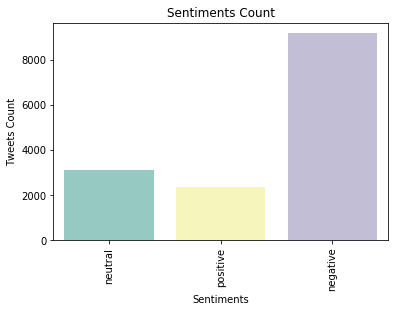

In [5]:
# Count of tweets for different Sentiments
sns.countplot(x=data['airline_sentiment'], palette="Set3")
plt.xticks(rotation =90)
plt.xlabel('Sentiments')
plt.ylabel('Tweets Count')
plt.title('Sentiments Count')
plt.show()

<Figure size 720x576 with 0 Axes>

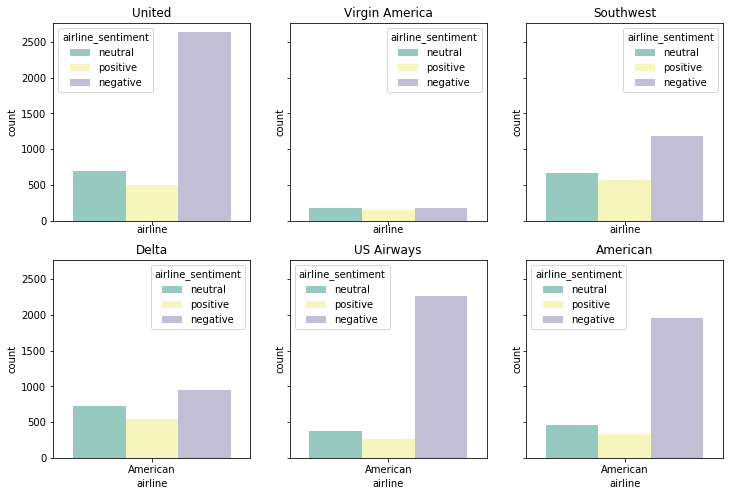

In [6]:
#count of each tweet for different airlines plotted on seperate plot using subplots by creating an array of plot 

plt.figure(figsize=(10,8))
f, ax = plt.subplots(2,3, figsize=(12,8), sharey=True, sharex=True)

sns.countplot(x = data[data['airline']=='United']['airline'], hue= data['airline_sentiment'], palette="Set3", ax= ax[0,0])
ax[0,0].set_title('United')

sns.countplot(x = data[data['airline']=='Virgin America']['airline'], hue= data['airline_sentiment'], palette="Set3", ax= ax[0,1])
ax[0,1].set_title('Virgin America')


sns.countplot(x = data[data['airline']=='Southwest']['airline'], hue= data['airline_sentiment'], palette="Set3", ax= ax[0,2])
ax[0,2].set_title('Southwest')

sns.countplot(x = data[data['airline']=='Delta']['airline'], hue= data['airline_sentiment'], palette="Set3", ax= ax[1,0])
ax[1,0].set_title('Delta')

sns.countplot(x = data[data['airline']=='US Airways']['airline'], hue= data['airline_sentiment'], palette="Set3", ax= ax[1,1])
ax[1,1].set_title('US Airways')

sns.countplot(x = data[data['airline']=='American']['airline'], hue= data['airline_sentiment'], palette="Set3", ax= ax[1,2])
ax[1,2].set_title('American')

plt.show()

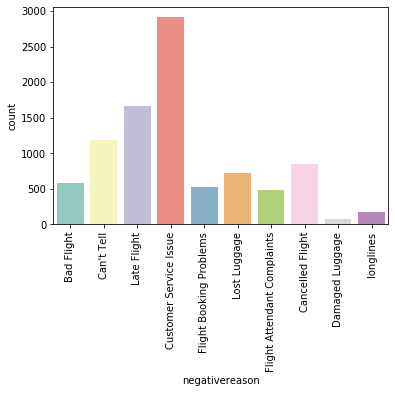

In [7]:
# Count of reasons for negative tweets for airlines, overall customer service issue was major problem
sns.countplot(x=data['negativereason'], palette="Set3")
plt.xticks(rotation =90)
plt.show()

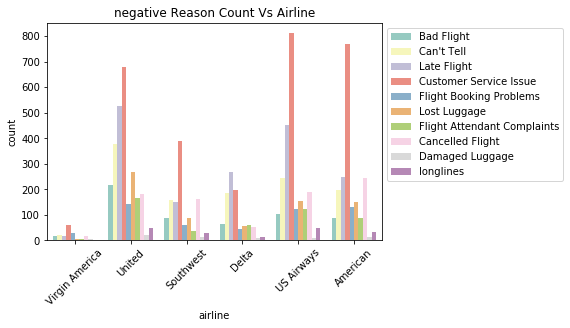

In [8]:
# US airways and American Airlines appears to have major customer service issue in the following plot
sns.countplot(x = data['airline'], hue= data['negativereason'], palette="Set3")
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor = (1,1))
plt.title('negative Reason Count Vs Airline')
plt.show()

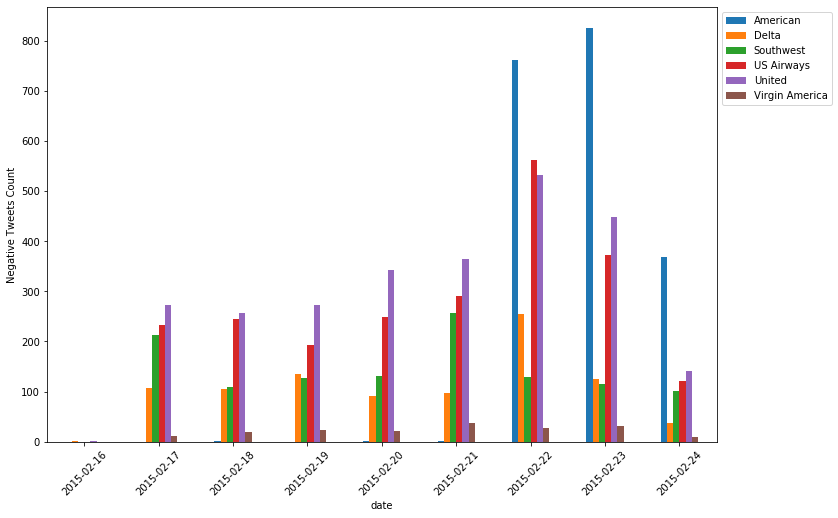

In [9]:
# Converting datetime column to pandas datetime format and keeping only date
data['date'] = pd.to_datetime(data['tweet_created'])
data['date'] = data['date'].apply(lambda x : x.date())

df1 = data.groupby(['date','airline','airline_sentiment']).size()
df1 = df1.loc(axis=0)[:,:,'negative']
axis = df1.groupby(['date', 'airline']).sum().unstack().plot(kind='bar', figsize=(12,8), rot=45)
axis.set_ylabel('Negative Tweets Count')
axis.legend(loc='upper left', bbox_to_anchor = (1,1))

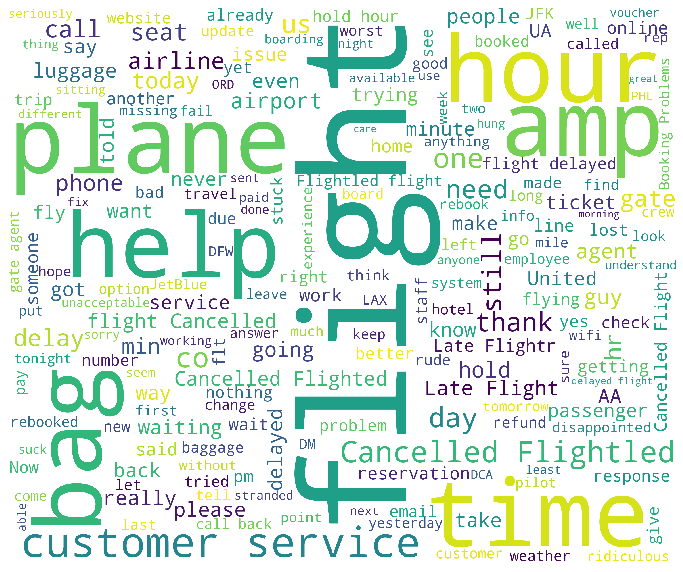

In [14]:
#wordcloud
#Topic words for negative sentiment
new_df=data[data['airline_sentiment']=='negative']
words = ' '.join(new_df['tidy_text'])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [10]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer  
cv = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')  
X = cv.fit_transform(corpus).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
sentiment = []
for i in range(0,len(data['airline_sentiment'])): 
    if data['airline_sentiment'][i]=='negative':
        sentiment.append(0)
    if data['airline_sentiment'][i]=='positive':
        sentiment.append(2)
    if data['airline_sentiment'][i]=='neutral':
        sentiment.append(1)
data['sentiment'] = sentiment
Y = data['sentiment'].values
Y

array([1, 2, 1, ..., 1, 0, 1])

# K-nn Model

In [12]:
from sklearn import metrics
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [15]:
# try K=1 through K=15 and record testing accuracy
k_range = list(range(1, 16))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(Y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

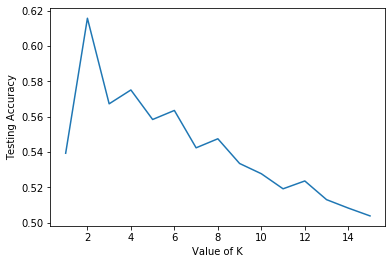

In [16]:
plt.plot(k_range, scores)
plt.xlabel('Value of K')
plt.ylabel('Testing Accuracy')

In [75]:
#With k = 2
kn = KNeighborsClassifier(n_neighbors=2)
model_knn = kn.fit(X_train,Y_train)
k_pred = model_knn.predict(X_test)
print(metrics.accuracy_score(Y_test,k_pred))

0.6157786885245902


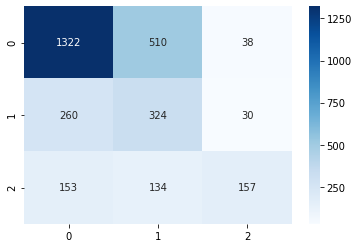

In [146]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,k_pred)
sns.heatmap(cm, annot=True, fmt = 'd',cmap="Blues")

# Logistic Regression

In [135]:
#1 - Logistic Regression classification with Pipeline
from sklearn.linear_model import LogisticRegression
X3_train, X3_test, Y3_train, Y3_test = train_test_split(data['tidy_text'],data['sentiment'], test_size = 0.2, random_state=0, shuffle = True, stratify=data['sentiment'])

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report
#Training and testing the randomforest model
rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', LogisticRegression())])
rf.fit(X3_train, Y3_train)
y_pred = rf.predict(X3_test)

LG_df = pd.crosstab(Y3_test,y_pred,rownames=['Actual'],colnames=['Predicted'])

print(classification_report(Y3_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.95      0.87      1836
           1       0.82      0.59      0.68       472
           2       0.71      0.45      0.55       620

    accuracy                           0.79      2928
   macro avg       0.77      0.66      0.70      2928
weighted avg       0.78      0.79      0.77      2928



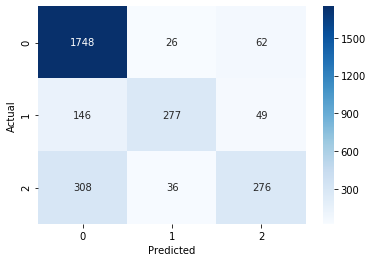

In [147]:
import seaborn as sns
sns.heatmap(LG_df, annot=True, fmt = 'd',cmap="Blues")

In [137]:
#Logistic Regression using 10 fold - cross validation
lr = LogisticRegression()
scores = cross_val_score(lr, X, Y, cv=10, scoring='accuracy')
print(scores)
s0 = scores.mean()
print(s0)

#Logistic Regression using 5 fold - cross validation
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
scores = cross_val_score(lr, X, Y, cv=5, scoring='accuracy')
print(scores)
s1 = scores.mean()
print(s1)

#Logistic Regression using 15 fold - cross validation
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
scores = cross_val_score(lr, X, Y, cv=15, scoring='accuracy')
print(scores)
s2 = scores.mean()
print(s2)

#Logistic Regression using 20 fold - cross validation
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
scores = cross_val_score(lr, X, Y, cv=20, scoring='accuracy')
print(scores)
s3 = scores.mean()
print(s3)

#Taking the average of 4 cross validated accuracies
print('Maximum accuracy of Logistic Regression is '+ str(max(s0,s1, s2 , s3)))

[0.7665529  0.75221843 0.75358362 0.77868852 0.75546448 0.74180328
 0.80464481 0.76571038 0.76691729 0.7879617 ]
0.7673545413754809
[0.7562308  0.75827928 0.76544896 0.78168773 0.77922078]
0.7681735088977417
[0.76560901 0.76458547 0.75742068 0.74718526 0.75742068 0.78607984
 0.74104401 0.78812692 0.8125     0.81948718 0.78564103 0.75794872
 0.76717949 0.78336756 0.78234086]
0.7743957787838408
[0.7680764  0.77216917 0.74897681 0.76775956 0.7636612  0.73907104
 0.75819672 0.78688525 0.7363388  0.78005464 0.78688525 0.81693989
 0.83060109 0.79781421 0.77459016 0.75409836 0.76502732 0.77868852
 0.80437756 0.77123288]
0.7750722418678004
Maximum accuracy of Logistic Regression is 0.7750722418678004


# Random Forest

In [140]:
from sklearn.ensemble import RandomForestClassifier

#1 - RandomForest classification with Pipeline
X2_train, X2_test, Y2_train, Y2_test = train_test_split(data['tidy_text'],data['sentiment'], test_size = 0.2, random_state=0, shuffle = True, stratify=data['sentiment'])


#Training and testing the randomforest model
rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])
rf.fit(X2_train, Y2_train)
y_pred = rf.predict(X2_test)

RF_df = pd.crosstab(Y2_test,y_pred,rownames=['Actual'],colnames=['Predicted'])

print(classification_report(Y2_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1836
           1       0.71      0.50      0.59       472
           2       0.61      0.40      0.48       620

    accuracy                           0.74      2928
   macro avg       0.70      0.61      0.64      2928
weighted avg       0.73      0.74      0.73      2928



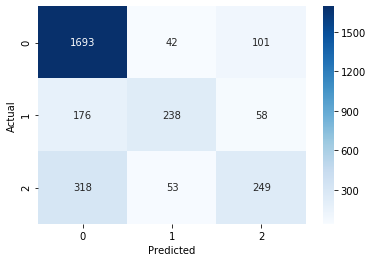

In [148]:
sns.heatmap(RF_df, annot=True, fmt = 'd',cmap="Blues")

In [144]:
#Random Forest using 5 fold Cross validation with 
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, Y, cv=5, scoring='accuracy')
print(scores)
s0 = scores.mean()

#Random Forest using 10 fold Cross validation with 
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, Y, cv=10, scoring='accuracy')
print(scores)
s1 = scores.mean()

#Random Forest using 15 fold Cross validation with 
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, Y, cv=15, scoring='accuracy')
print(scores)
s2 = scores.mean()

#Random Forest using 15 fold Cross validation with 
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, Y, cv=20, scoring='accuracy')
print(scores)
s3 = scores.mean()

print('Maximum accuracy of Random Forest is '+ str(max(s0,s1,s2,s3)))

[0.72686924 0.7183339  0.72721065 0.73727366 0.73889269]
[0.72764505 0.7105802  0.71194539 0.71584699 0.70013661 0.71174863
 0.75       0.72131148 0.71701982 0.75239398]
[0.71954964 0.72876151 0.72466735 0.71238485 0.71954964 0.71033777
 0.6642784  0.74206755 0.76434426 0.77538462 0.75384615 0.71384615
 0.73538462 0.75770021 0.75154004]
[0.7053206  0.73260573 0.72032742 0.71311475 0.71448087 0.71584699
 0.71038251 0.74043716 0.67759563 0.69945355 0.74043716 0.7636612
 0.75409836 0.75546448 0.74453552 0.71584699 0.70901639 0.74043716
 0.75649795 0.74109589]
Maximum accuracy of Random Forest is 0.7315761847887026


# Tensorflow

In [15]:
Y = data['airline_sentiment']
lenc = LabelEncoder()
Y = lenc.fit_transform(Y)
Y = to_categorical(Y)

X_train, X_test, Y_train, Y_test = train_test_split(data['tidy_text'], Y, test_size=0.2,random_state=37)
max_words = len(set(" ".join(X_train).split()))
max_len = X_train.apply(lambda x: len(x)).max()
max_words, max_len

(14386, 135)

In [17]:
tk = Tokenizer(num_words=max_words)
tk.fit_on_texts(X_train)
X_train_tk = tk.texts_to_sequences(X_train)
X_test_tk = tk.texts_to_sequences(X_test)
X_train_pad = sequence.pad_sequences(X_train_tk, maxlen = max_len)
X_test_pad = sequence.pad_sequences(X_test_tk, maxlen = max_len)
num_classes = 3

def get_weight(y):
    class_weight_current =  cw.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

class_weight = get_weight(Y_train.flatten())
base_model = Sequential()
base_model.add(Embedding(max_words, 8, input_length=max_len))
base_model.add(Flatten())
base_model.add(Dense(64, activation='relu'))
base_model.add(Dense(64, activation='relu'))
base_model.add(Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 135, 8)            115088    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1080)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                69184     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 188,627
Trainable params: 188,627
Non-trainable params: 0
_________________________________________________________________


In [18]:
def deep_lr_model(model):
    batch_size = 512
    epochs = 20


    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train_pad, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1,class_weight=class_weight)
    
    return history
base_history = deep_lr_model(base_model)

/Users/markhu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9369 samples, validate on 2343 samples
Epoch 1/20
9369/9369 [==============================] - 0s 35us/step - loss: 0.9582 - accuracy: 0.5993 - val_loss: 0.9137 - val_accuracy: 0.6240
Epoch 2/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.8875 - accuracy: 0.6248 - val_loss: 0.8734 - val_accuracy: 0.6240
Epoch 3/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.8108 - accuracy: 0.6311 - val_loss: 0.7978 - val_accuracy: 0.6372
Epoch 4/20
9369/9369 [==============================] - 0s 14us/step - loss: 0.7289 - accuracy: 0.6740 - val_loss: 0.7342 - val_accuracy: 0.6778
Epoch 5/20
9369/9369 [==============================] - 0s 14us/step - loss: 0.6449 - accuracy: 0.7063 - val_loss: 0.7047 - val_accuracy: 0.6876
Epoch 6/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.5755 - accuracy: 0.7496 - val_loss: 0.6620 - val_accuracy: 0.7106
Epoch 7/20
9369/9369 [==============================] - 0s 14us/step - loss: 0.515

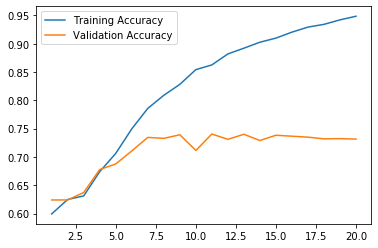

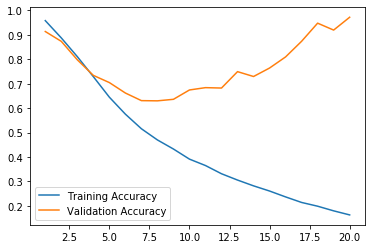

In [19]:
def plot_performance(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_'+metric_name]
    ep = range(1,21)
    plt.plot(ep,metric,label="Training Accuracy")
    plt.plot(ep,val_metric,label="Validation Accuracy")
    plt.legend()
    plt.show()
    
plot_performance(base_history,'accuracy')
plot_performance(base_history,'loss')

In [20]:
def test_model(model, epoch_stop):
    model.fit(X_train_pad
              , Y_train
              , epochs=epoch_stop
              , batch_size=512
              , verbose=1)
    results = model.evaluate(X_test_pad, Y_test)
    
    return results

base_results = test_model(base_model, 10)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

Epoch 1/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.3055 - accuracy: 0.9080
Epoch 2/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.2632 - accuracy: 0.9185
Epoch 3/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.2406 - accuracy: 0.9267
Epoch 4/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.2182 - accuracy: 0.9333
Epoch 5/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.1955 - accuracy: 0.9408
Epoch 6/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.1750 - accuracy: 0.9487
Epoch 7/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.1577 - accuracy: 0.9530
Epoch 8/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.1397 - accuracy: 0.9589
Epoch 9/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.1226 - accuracy: 0.9642
Epoch 10/10
2928/2928 [==============================] 

/Users/markhu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9369 samples, validate on 2343 samples
Epoch 1/20
9369/9369 [==============================] - 0s 25us/step - loss: 0.9231 - accuracy: 0.6003 - val_loss: 0.9066 - val_accuracy: 0.6240
Epoch 2/20
9369/9369 [==============================] - 0s 14us/step - loss: 0.8526 - accuracy: 0.6262 - val_loss: 0.8250 - val_accuracy: 0.6265
Epoch 3/20
9369/9369 [==============================] - 0s 14us/step - loss: 0.7734 - accuracy: 0.6500 - val_loss: 0.7688 - val_accuracy: 0.6628
Epoch 4/20
9369/9369 [==============================] - 0s 14us/step - loss: 0.7023 - accuracy: 0.6855 - val_loss: 0.7215 - val_accuracy: 0.6786
Epoch 5/20
9369/9369 [==============================] - 0s 15us/step - loss: 0.6387 - accuracy: 0.7109 - val_loss: 0.6842 - val_accuracy: 0.6953
Epoch 6/20
9369/9369 [==============================] - 0s 15us/step - loss: 0.5797 - accuracy: 0.7312 - val_loss: 0.6589 - val_accuracy: 0.7256
Epoch 7/20
9369/9369 [==============================] - 0s 14us/step - loss: 0.530

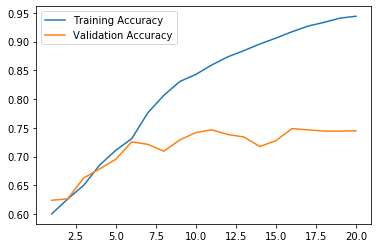

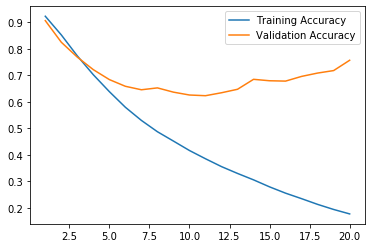

Epoch 1/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.2770 - accuracy: 0.9116
Epoch 2/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.2421 - accuracy: 0.9212
Epoch 3/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.2194 - accuracy: 0.9271
Epoch 4/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.1968 - accuracy: 0.9354
Epoch 5/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.1776 - accuracy: 0.9417
Epoch 6/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.1581 - accuracy: 0.9505
Epoch 7/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.1430 - accuracy: 0.9543
Epoch 8/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.1259 - accuracy: 0.9618
Epoch 9/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.1127 - accuracy: 0.9657
Epoch 10/10
2928/2928 [==============================] 

In [21]:
reg_model = Sequential()
reg_model.add(Embedding(max_words, 8, input_length=max_len))
reg_model.add(Flatten())
reg_model.add(Dense(128, activation='relu'))
reg_model.add(Dense(3, activation='softmax'))

reg_history = deep_lr_model(reg_model)

plot_performance(reg_history,'accuracy')
plot_performance(reg_history,'loss')

reg_results = test_model(reg_model, 10)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(reg_results[1]*100))

/Users/markhu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9369 samples, validate on 2343 samples
Epoch 1/20
9369/9369 [==============================] - 0s 23us/step - loss: 1.0222 - accuracy: 0.5975 - val_loss: 0.9769 - val_accuracy: 0.6240
Epoch 2/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.9228 - accuracy: 0.6249 - val_loss: 0.8906 - val_accuracy: 0.6419
Epoch 3/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.8336 - accuracy: 0.6401 - val_loss: 0.8317 - val_accuracy: 0.6381
Epoch 4/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.7599 - accuracy: 0.6729 - val_loss: 0.7739 - val_accuracy: 0.6799
Epoch 5/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.6973 - accuracy: 0.7113 - val_loss: 0.7457 - val_accuracy: 0.6889
Epoch 6/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.6460 - accuracy: 0.7429 - val_loss: 0.7235 - val_accuracy: 0.7187
Epoch 7/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.603

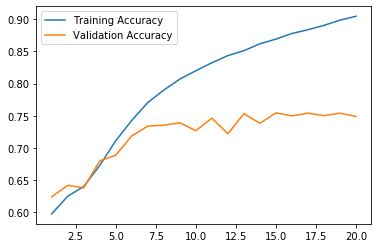

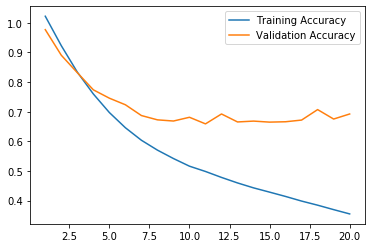

Epoch 1/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.4108 - accuracy: 0.8788
Epoch 2/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.3889 - accuracy: 0.8893
Epoch 3/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.3700 - accuracy: 0.8961
Epoch 4/10
11712/11712 [==============================] - 0s 9us/step - loss: 0.3537 - accuracy: 0.9035
Epoch 5/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.3363 - accuracy: 0.9086
Epoch 6/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.3224 - accuracy: 0.9149
Epoch 7/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.3064 - accuracy: 0.9189
Epoch 8/10
11712/11712 [==============================] - 0s 10us/step - loss: 0.2927 - accuracy: 0.9246
Epoch 9/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.2766 - accuracy: 0.9294
Epoch 10/10
2928/2928 [==============================] -

In [22]:
from keras import regularizers

drop1_model = Sequential()
drop1_model.add(Embedding(max_words, 8, input_length=max_len))
drop1_model.add(Flatten())
drop1_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
drop1_model.add(Dense(3, activation='softmax'))

rgz_history = deep_lr_model(drop1_model)

plot_performance(rgz_history,'accuracy')
plot_performance(rgz_history,'loss')

rgz_results = test_model(drop1_model, 10)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(rgz_results[1]*100))

/Users/markhu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9369 samples, validate on 2343 samples
Epoch 1/20
9369/9369 [==============================] - 0s 28us/step - loss: 0.9291 - accuracy: 0.6126 - val_loss: 0.8971 - val_accuracy: 0.6240
Epoch 2/20
9369/9369 [==============================] - 0s 12us/step - loss: 0.8797 - accuracy: 0.6249 - val_loss: 0.8514 - val_accuracy: 0.6240
Epoch 3/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.8153 - accuracy: 0.6285 - val_loss: 0.8380 - val_accuracy: 0.6560
Epoch 4/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.7577 - accuracy: 0.6545 - val_loss: 0.7712 - val_accuracy: 0.6675
Epoch 5/20
9369/9369 [==============================] - 0s 14us/step - loss: 0.7027 - accuracy: 0.6835 - val_loss: 0.7224 - val_accuracy: 0.6846
Epoch 6/20
9369/9369 [==============================] - 0s 14us/step - loss: 0.6379 - accuracy: 0.7201 - val_loss: 0.6873 - val_accuracy: 0.7320
Epoch 7/20
9369/9369 [==============================] - 0s 13us/step - loss: 0.587

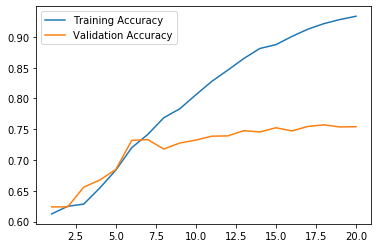

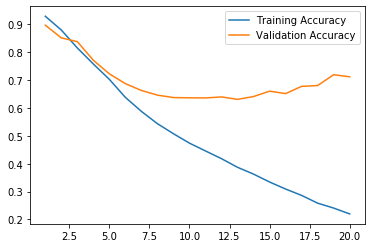

Epoch 1/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.3073 - accuracy: 0.9038
Epoch 2/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.2809 - accuracy: 0.9133
Epoch 3/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.2575 - accuracy: 0.9189
Epoch 4/10
11712/11712 [==============================] - 0s 12us/step - loss: 0.2337 - accuracy: 0.9277
Epoch 5/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.2147 - accuracy: 0.9333
Epoch 6/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.1976 - accuracy: 0.9372
Epoch 7/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.1791 - accuracy: 0.9451
Epoch 8/10
11712/11712 [==============================] - 0s 11us/step - loss: 0.1621 - accuracy: 0.9506
Epoch 9/10
11712/11712 [==============================] - 0s 10us/step - loss: 0.1522 - accuracy: 0.9535
Epoch 10/10
2928/2928 [==============================] 

In [23]:
drop_model = Sequential()
drop_model.add(Embedding(max_words, 8, input_length=max_len))
drop_model.add(Flatten())
drop_model.add(Dense(64, activation='relu'))
drop_model.add(Dropout(0.5))
drop_model.add(Dense(3, activation='softmax'))


drop_history = deep_lr_model(drop_model)

plot_performance(drop_history,'accuracy')
plot_performance(drop_history,'loss')

drop_results = test_model(drop_model, 10)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(drop_results[1]*100))


In [111]:
X_text = data.iloc[:, 12].values

Y_text = data.iloc[:, 1].values

X_text_train, X_text_test, Y_text_train, Y_text_test = train_test_split(X_text, Y_text, test_size=0.2, random_state=42)

In [112]:
vocab_size = 1000

tokenizer = Tokenizer(num_words=vocab_size)

tokenizer.fit_on_texts(X_text_train)

train_tweets = tokenizer.texts_to_matrix(X_text_train, mode='tfidf')

test_tweets = tokenizer.texts_to_matrix(X_text_test, mode='tfidf')

In [115]:
encoder = LabelBinarizer()

encoder.fit(Y_text_train)

train_sentiment = encoder.transform(Y_text_train)

test_sentiment = encoder.transform(Y_text_test)
print(test_sentiment)

[[0 0 1]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [1 0 0]]


In [116]:
model = Sequential()

model.add(Dense(512, input_shape=(vocab_size,)))

model.add(Activation('relu'))

model.add(Dropout(0.3))

model.add(Dense(512))

model.add(Activation('relu'))

model.add(Dropout(0.3))

model.add(Dense(512))

model.add(Activation('relu'))

model.add(Dropout(0.3))

model.add(Dense(3))

model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',

optimizer='adam',

metrics=['accuracy'])

model_info = model.fit(train_tweets, train_sentiment,

batch_size=32,

epochs=20,

verbose=1,

validation_split=0.1)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 512)               512512    
_________________________________________________________________
activation_48 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_49 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)             

In [119]:
act_result = model.evaluate(test_tweets, test_sentiment,

batch_size=32, verbose=1)

print('Test accuracy: ', act_result [1])

2928/2928 [==============================] - 0s 72us/step
Test accuracy:  0.7749316692352295


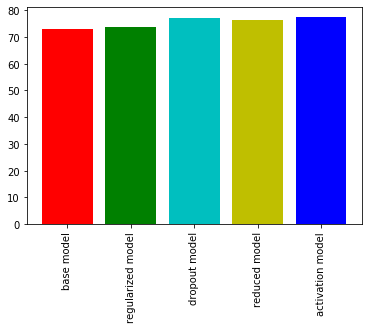

In [120]:
score = []
score.append(base_results[1]*100)
score.append(reg_results[1]*100)
score.append(rgz_results[1]*100)
score.append(drop_results[1]*100)
score.append(act_result [1]*100)

l = ['base model','regularized model', 'dropout model','reduced model','activation model']
index = [1,2,3,4,5]
plt.bar(index,score,color='rgcyb')
plt.xticks(index,['base model','regularized model', 'dropout model','reduced model','activation model'],rotation=90)
plt.show()